#### S/19/809

### Import Important Libraries

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

### Exploratory Data Analysis

In [70]:
# Load data
df = pd.read_csv("student_habits_performance.csv")
df = df.drop(columns=['student_id'])

In [71]:
# Check for Null Values
df.isnull().sum()

age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

In [72]:
# Drop Null Values
df.dropna(inplace=True)

In [73]:
# numerical columns
cont_cols = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
             'attendance_percentage', 'sleep_hours', 'exercise_frequency',
             'mental_health_rating', 'exam_score']

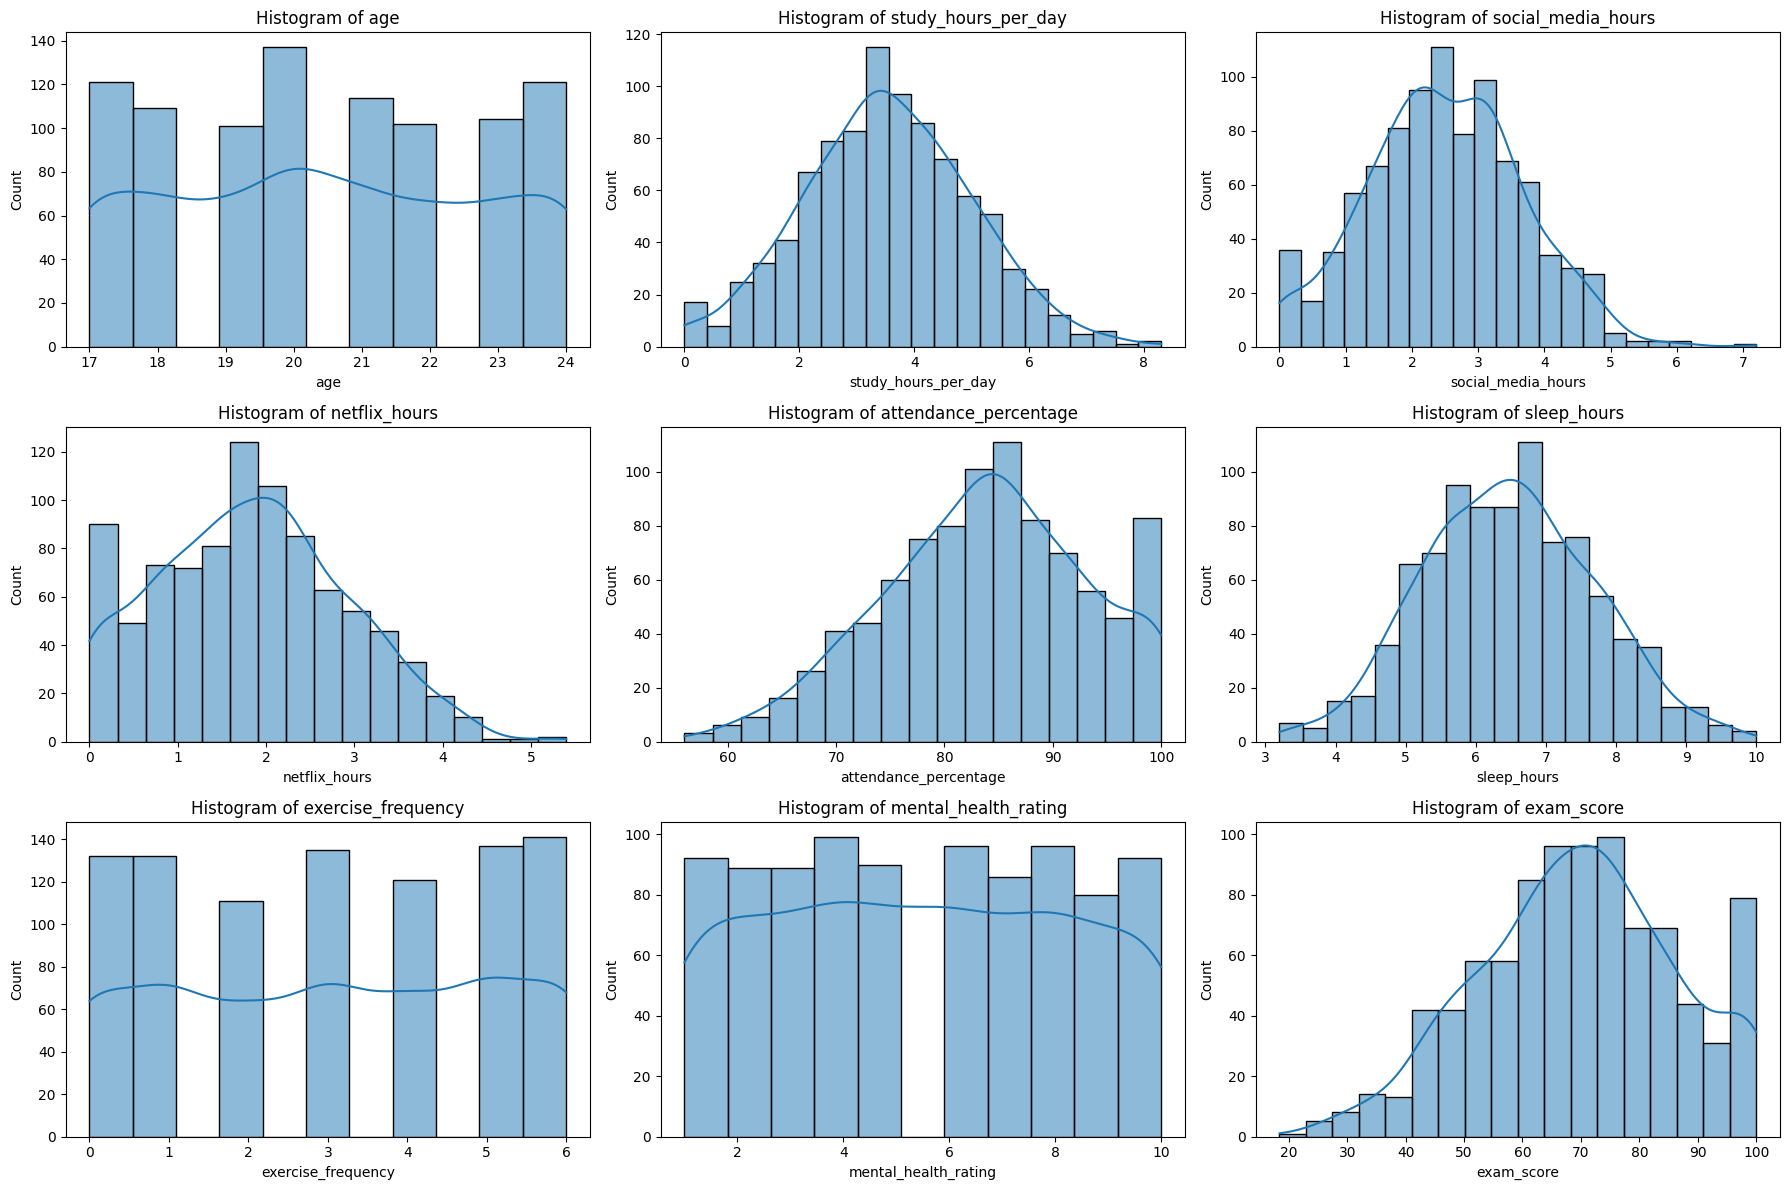

In [74]:
# Plot histograms of numerical variables
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
for ax, col in zip(axes.flatten(), cont_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

In [75]:
# Correct skewness using log1p where necessary
for col in cont_cols:
    if skew(df[col]) > 1:
        df[col] = np.log1p(df[col])
    elif skew(df[col]) < -1:
        df[col] = np.log1p(df[col].max() + 1 - df[col])

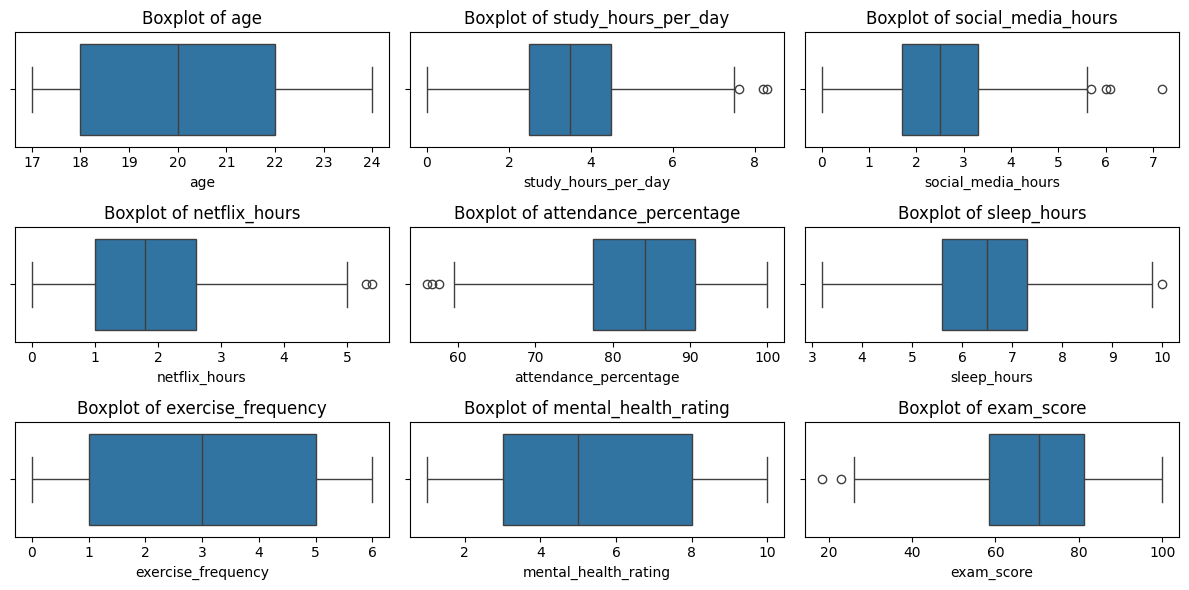

In [76]:
# Plot boxplots 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 6))
for ax, col in zip(axes.flatten(), cont_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [77]:
# Drop outliers using IQR method
Q1 = df[cont_cols].quantile(0.25)
Q3 = df[cont_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[cont_cols] < (Q1 - 1.5 * IQR)) | (df[cont_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

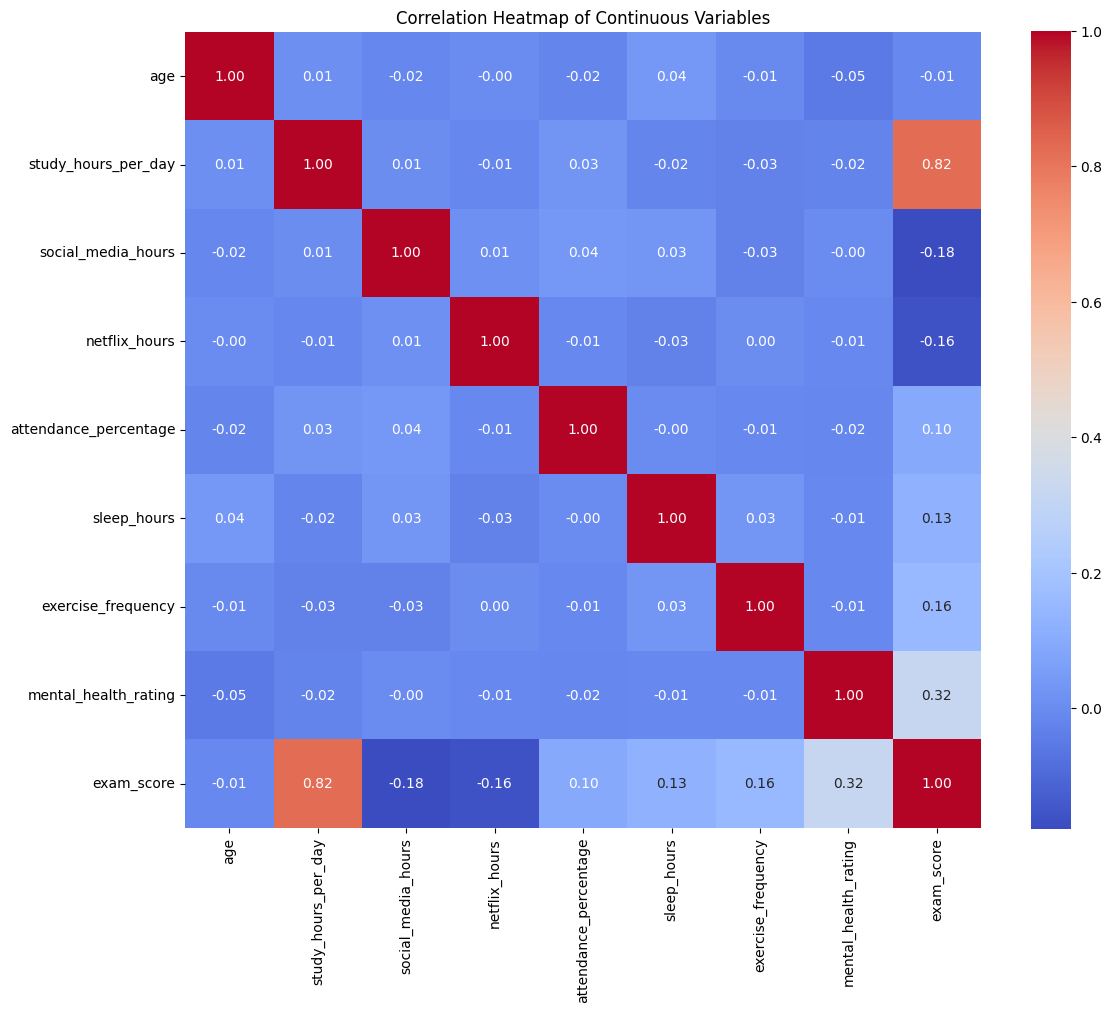

In [78]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df[cont_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Continuous Variables')
plt.tight_layout()
plt.show()

In [79]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

In [80]:
# Standardize continuous variables for PCA/Clustering
scaler = StandardScaler()
df_encoded[cont_cols] = scaler.fit_transform(df_encoded[cont_cols])

### Principal Component Analysis (PCA)

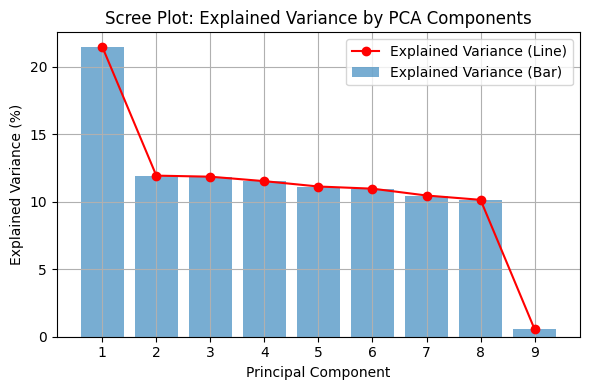

In [81]:
# Scree Plot
pca_full = PCA()
pca_full.fit(df_encoded[cont_cols])
explained = pca_full.explained_variance_ratio_ * 100

plt.figure(figsize=(6, 4))
components = range(1, len(explained) + 1)

# Plot bars
plt.bar(components, explained, alpha=0.6, label='Explained Variance (Bar)')

# Plot line for explained variance
plt.plot(components, explained, marker='o', linestyle='-', color='r', label='Explained Variance (Line)')

plt.title('Scree Plot: Explained Variance by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(components)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
pca = PCA(n_components=4)
pca_components = pca.fit_transform(df_encoded[cont_cols])
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

explained_variance_pct = pca.explained_variance_ratio_ * 100
total_variance = explained_variance_pct.sum()
print("\nTotal Explained Variance by First 4 Components: {:.1f}%".format(total_variance))

print("\nPCA Component Loadings:")
print(pd.DataFrame(pca.components_, columns=cont_cols, index=['PC1', 'PC2', 'PC3', 'PC4']))


Total Explained Variance by First 4 Components: 56.8%

PCA Component Loadings:
          age  study_hours_per_day  social_media_hours  netflix_hours  \
PC1 -0.011974             0.619688           -0.130961      -0.141067   
PC2  0.607187            -0.010277           -0.138231      -0.160850   
PC3  0.143993             0.276097            0.553563      -0.004665   
PC4 -0.294556            -0.281984            0.411437      -0.321082   

     attendance_percentage  sleep_hours  exercise_frequency  \
PC1               0.082437     0.085022            0.102018   
PC2              -0.168693     0.523888            0.316935   
PC3               0.513896     0.079056           -0.414148   
PC4               0.193727     0.563358            0.252679   

     mental_health_rating  exam_score  
PC1              0.224676    0.709846  
PC2             -0.427555    0.008366  
PC3             -0.392693   -0.022737  
PC4              0.377547    0.007512  


### Cluster Analysis (K-Means)

Optimal number of clusters based on silhouette score: 2


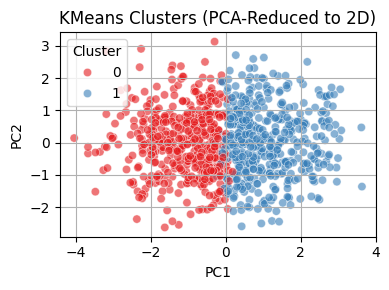

In [83]:
# Determine optimal number of clusters using silhouette score
silhouette_scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_encoded[cont_cols])
    score = silhouette_score(df_encoded[cont_cols], labels)
    silhouette_scores[k] = score

optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_encoded['cluster'] = kmeans.fit_predict(df_encoded[cont_cols])

# Reduce to 2 components for visualization
pca_2d = PCA(n_components=2)
components_2d = pca_2d.fit_transform(df_encoded[cont_cols])

pca_cluster_df = pd.DataFrame(components_2d, columns=['PC1', 'PC2'])
pca_cluster_df['Cluster'] = df_encoded['cluster'].values

plt.figure(figsize=(4, 3))
sns.scatterplot(data=pca_cluster_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.6)
plt.title('KMeans Clusters (PCA-Reduced to 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
# Compute mean values per cluster
group_summary = df_encoded.groupby('cluster')[['study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'mental_health_rating', 'exam_score']].mean()
print(group_summary)

         study_hours_per_day  social_media_hours  netflix_hours  \
cluster                                                           
0                  -0.652950            0.167643       0.166875   
1                   0.635654           -0.163203      -0.162454   

         attendance_percentage  sleep_hours  mental_health_rating  exam_score  
cluster                                                                        
0                    -0.088654    -0.169615             -0.332465   -0.808902  
1                     0.086306     0.165122              0.323658    0.787474  


### Discriminant Analysis (LDA)

In [85]:
# Discriminant Analysis 
df["score_cat"] = pd.cut(df["exam_score"], bins=[0, 60, 80, 100], labels=["Low", "Medium", "High"])
X = df_encoded.drop(columns=["exam_score", "cluster"])
y = df["score_cat"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("\nDiscriminant Analysis Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Get loadings (coefficients) for each discriminant function
loadings = pd.DataFrame(lda.coef_.T, index=X_train.columns, columns=['LD1', 'LD2', 'LD3'])

# Display the full loading matrix
print("LDA Loadings (Coefficients for each Linear Discriminant Function):")
print(loadings)


Discriminant Analysis Accuracy: 0.8847583643122676

Classification Report:
              precision    recall  f1-score   support

        High       0.93      0.85      0.89        81
         Low       0.91      0.91      0.91        78
      Medium       0.84      0.89      0.86       110

    accuracy                           0.88       269
   macro avg       0.89      0.88      0.89       269
weighted avg       0.89      0.88      0.89       269

LDA Loadings (Coefficients for each Linear Discriminant Function):
                                           LD1       LD2       LD3
age                                  -0.020991  0.045847 -0.016250
study_hours_per_day                   4.410360 -4.149786  0.040118
social_media_hours                   -1.031841  0.932855  0.014012
netflix_hours                        -0.677807  0.660533 -0.020179
attendance_percentage                 0.532509 -0.444075 -0.030216
sleep_hours                           0.790419 -0.700824 -0.019207
exercis

### MANOVA

In [86]:
manova_data = df[["exam_score", "mental_health_rating", "diet_quality",
                  "parental_education_level", "internet_quality", "part_time_job", "extracurricular_participation"]]
manova = MANOVA.from_formula(
    "exam_score + mental_health_rating ~ diet_quality + parental_education_level + internet_quality + part_time_job + extracurricular_participation",
    data=manova_data
)
print("\nMANOVA Results:")
print(manova.mv_test())


MANOVA Results:
                     Multivariate linear model
                                                                    
---------------------------------------------------------------------
        Intercept         Value   Num DF   Den DF    F Value   Pr > F
---------------------------------------------------------------------
           Wilks' lambda  0.2418  2.0000  884.0000  1385.9390  0.0000
          Pillai's trace  0.7582  2.0000  884.0000  1385.9390  0.0000
  Hotelling-Lawley trace  3.1356  2.0000  884.0000  1385.9390  0.0000
     Roy's greatest root  3.1356  2.0000  884.0000  1385.9390  0.0000
--------------------------------------------------------------------
                                                                    
---------------------------------------------------------------------
        diet_quality       Value   Num DF    Den DF   F Value  Pr > F
---------------------------------------------------------------------
            Wilks' lambda  0.